## Modelling
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("data/transactions.parquet")

In [3]:
df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
    ]
] = df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
    ]
].astype("string")
df["Order_Date_FK"] = pd.to_datetime(df["Order_Date_FK"], format="%Y%m%d")
df["Month"] = df["Order_Date_FK"].dt.month
df["Day"] = df["Order_Date_FK"].dt.day
df["Weekday"] = df["Order_Date_FK"].dt.weekday
df.drop(columns=["Order_Date_FK"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759889 entries, 0 to 1759888
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Shop                       string 
 1   ProductCode                string 
 2   OriginalSaleAmountInclVAT  float64
 3   CustomerID                 string 
 4   SaleDocumentNumber         string 
 5   Returned                   int64  
 6   RevenueInclVAT             float64
 7   CostPriceExclVAT           float64
 8   BrandName                  string 
 9   ModelGroup                 string 
 10  ProductGroup               string 
 11  Month                      int32  
 12  Day                        int32  
 13  Weekday                    int32  
dtypes: float64(3), int32(3), int64(1), string(7)
memory usage: 167.8 MB


In [4]:
# df.drop_duplicates(inplace=True)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
    f1_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
)

from sklearn.model_selection import train_test_split

# In terminal : 
pip install mlflow



# In terminal :  
```mlflow server --backend-store-uri file:C:\Users\Jean\Desktop\becode_projects\ds-recruitement-challenge-shoes\mlflow_models```
This is what creates the local pointer 

- **mlflow-db** is the name of the folder that will be created (if non existent)  where the model info will be stored
- when the above is executed the **system send back** **a local machine address like :  h[ttp://127.0.0.1:5000/](http://127.0.0.1:5000/)** >> copy paste in navigator , et voila
- you can run at anytime in the terminal  “mlflow ui “ which should give you back the address

# in VS code : 
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset

In [6]:
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
import mlflow

In [16]:
# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [8]:
# Split the data into features (X) and target (y)
X = df.drop("Returned", axis=1)
y = df["Returned"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# rfc_model = rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
y_pred = rf.predict(X_test)
print(y_pred, y_pred.shape)

# Calculate the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision_score * 100))
print("Recall: {:.2f}%".format(recall_score * 100))
print("F1 Score: {:.2f}".format(f1))


# Display the classification report and confusion matrix.

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[0 0 0 ... 0 0 0] (351978,)
Accuracy: 97.88%
Precision: 89.46%
Recall: 50.88%
F1 Score: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    338450
           1       0.89      0.51      0.65     13528

    accuracy                           0.98    351978
   macro avg       0.94      0.75      0.82    351978
weighted avg       0.98      0.98      0.98    351978

Confusion Matrix:
[[337639    811]
 [  6645   6883]]


In [11]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best Threshold=%f" % (best_thresh))

Best Threshold=0.062000


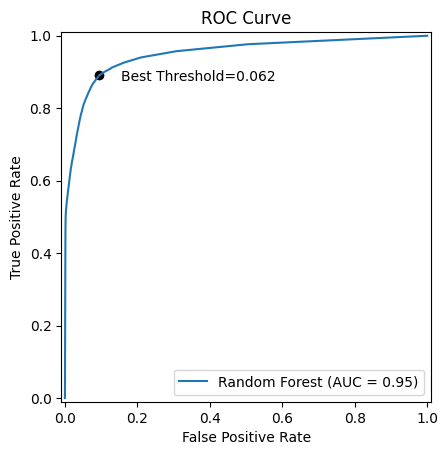

In [12]:
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest"
)
display.plot()
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black")
plt.text(fpr[ix] + 0.06, tpr[ix] - 0.015, f"Best Threshold={best_thresh}")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

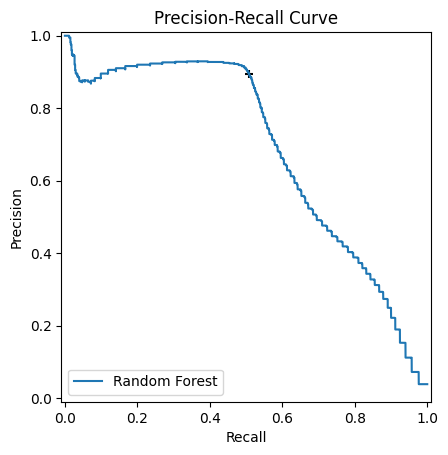

In [13]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(
    precision=prec, recall=recall, estimator_name="Random Forest"
)
pr_display.plot()
plt.scatter(recall_score, precision_score, marker="+", color="black")
# plt.axvline(x=0.51, color="green", linestyle="--")
# plt.axhline(y=0.89, color="red", linestyle="--")
plt.title("Precision-Recall Curve")
plt.show()

In [15]:
"""
mlflow.set_experiment("Returns_predictions_RF")

# Mention the dataset used
dataset: PandasDataset = mlflow.data.from_pandas(
    df, source="../data/transactions.parquet"
)


# Start an MLflow run
with mlflow.start_run():
    # Log the input data
    # mlflow.log_input(dataset, context="TRN")
    # mlflow.log_artifact("df.csv")

    # Log the hyperparameters from the model (they should in the variable in the code)
    # mlflow.log_params(param)

    # log the rando and TT split
    mlflow.log_param("testsplit_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Log the loss metric
    mlflow.log_metric("accuracy_test", accuracy)
    mlflow.log_metric("precision", precision_score)
    mlflow.log_metric("recall", recall_score)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_score", roc_auc)
    # mlflow.log_metric("curve", curve)
    # mlflow.log_metric("conf_matrix", conf)
    # mlflow.log_metric("support", support)
    # mlflow.log_metric("classification", classification)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag(
        "Comments",
        "Basic RFC model, removed duplicates, added date features. Changed model in model_info",
    )

    # if prediction are not runed in the model (cause cluster for ex) run them here
    # predictions = ward.fit_predict(dfs)

    # Infer the model signature
    signature = infer_signature(X_test, y_pred)

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,  # model to log
        artifact_path="RFC",  # local path for saving that model
        signature=signature,  # log the scheme of input&output - names, datatype, shape tec..
        input_example=df,  # useful for model later use to check/exemplify the right data format
        registered_model_name="RFC",  # name of the model in the mlflow UI
    )
"""


2024/04/11 11:10:57 INFO mlflow.tracking.fluent: Experiment with name 'Returns_predictions_RF' does not exist. Creating a new experiment.


c:\Users\Jean\Desktop\becode_projects\ds-recruitement-challenge-shoes\venv\Lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\Jean\Desktop\becode_projects\ds-recruitement-challenge-shoes\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


KeyboardInterrupt: 

In [20]:
random_grid = {
    "n_estimators": [int(x) for x in np.linspace(start=10, stop=80, num=10)],
    "bootstrap": [True, False],
    "max_depth": [4, 10, 20, 30, 40, 50, 60],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [130, 180, 230],
}


In [ ]:
cv_rfc = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_RandomGrid = RandomizedSearchCV(
    estimator=rf_Model, param_distributions=param_grid, cv=10, verbose=2, n_jobs=4
)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

In [ ]:
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(X_train, y_train)

In [ ]:
CV_rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
rf_random.fit(X_1, Y)

NameError: name 'X_1' is not defined